<a href="https://colab.research.google.com/github/eveOfCode/Have-Taylor-Swift-Songs-Become-Happier-or-Sadder-/blob/main/Has_Taylor_Swift_songs_become_happier_or_sadder%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install Libraries
-------------------------
A library is a reusable chuck of code that can be downloaded (installed) for your project.

In [416]:
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


2. Import packages 

---
A package is function usually used for a particular/specific task. It's different to a library as a library is a group of functions or packages. Basically, these will help us with our code and it's not important 

In [417]:
from gensim.summarization import keywords
from spacy.lang.en import English
from nltk.corpus import stopwords
from google.colab import files
from textblob import TextBlob
import pandas as pd
import spacy
import nltk

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
nlp = English()
nlp.max_length = 10000000

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


4. Import Taylor Swift song data

In [418]:
songs_df = pd.read_excel('https://query.data.world/s/wupw3xoyppvnsm4khcsravrn73v7id')

In [419]:
songs_df

,TITLE,ALBUM,ARTIST,RELEASED_AT,LYRICS
0,Tim McGraw,Taylor Swift,Taylor Swift,2006-06-19,[Verse 1]\nHe said the way my blue eyes shined...
1,Picture to Burn,Taylor Swift,Taylor Swift,2006-10-24,"[Verse 1]\nState the obvious, I didn't get my ..."
2,Teardrops On My Guitar,Taylor Swift,Taylor Swift,2006-10-24,[Verse 1]\nDrew looks at me\nI fake a smile so...
3,A Place In This World,Taylor Swift,Taylor Swift,2006-10-24,"[Verse 1]\nI don't know what I want, so don't ..."
4,Cold as You,Taylor Swift,Taylor Swift,2006-10-24,[Verse 1]\nYou have a way of coming easily to ...
...,...,...,...,...,...
120,Everything has changed,Red,Taylor Swift,2012-10-22,All I knew\nThis morning when I woke\nIs I kno...
121,Bad Blood,1989,Taylor Swift,2014-10-27,Cause baby now we got bad blood\nYou know it u...
122,End Game,reputation,Taylor Swift,2014-10-27,I wanna be your endgame\nI wanna be your first...
123,Me!,Lover,Taylor Swift,2019-08-23,I promise that you'll never find another like ...


In [ ]:
for i in songs_df.loc[songs_df.TITLE == 'Tim McGraw'].LYRICS:
  print(i)

In [421]:
# Clean data a bit
# songs_df['LYRICS'] = songs_df['LYRICS'].str.replace('[^\w\s]',' ') 
songs_df['LYRICS'] = songs_df['LYRICS'].str.replace('\]',' ') # remove square brackets
songs_df['LYRICS'] = songs_df['LYRICS'].str.replace('\[',' ') # remove square brackets
songs_df['LYRICS'] = songs_df['LYRICS'].str.replace('[.,()!;:"]','') # remove certain punctuation


In [422]:
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Verse 1 \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Verse 2 \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Verse 3 \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Verse 4 \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Chorus \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Pre-Chorus \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Bridge \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Outro \n', '', regex=True)
songs_df.LYRICS = songs_df.LYRICS.str.replace(' Refrain \n', '', regex=True)

In [424]:
songs_df.LYRICS = songs_df.LYRICS.replace('\n',' ', regex=True) # remove control character newline
songs_df.LYRICS = songs_df.LYRICS.str.lower() # convert text to lowercase 

In [ ]:
for i in songs_df.loc[songs_df.TITLE == 'Tim McGraw'].LYRICS:
  print(i)

In [426]:
songs_df

,TITLE,ALBUM,ARTIST,RELEASED_AT,LYRICS
0,Tim McGraw,Taylor Swift,Taylor Swift,2006-06-19,he said the way my blue eyes shined put those ...
1,Picture to Burn,Taylor Swift,Taylor Swift,2006-10-24,state the obvious i didn't get my perfect fant...
2,Teardrops On My Guitar,Taylor Swift,Taylor Swift,2006-10-24,drew looks at me i fake a smile so he won't se...
3,A Place In This World,Taylor Swift,Taylor Swift,2006-10-24,i don't know what i want so don't ask me cause...
4,Cold as You,Taylor Swift,Taylor Swift,2006-10-24,you have a way of coming easily to me and when...
...,...,...,...,...,...
120,Everything has changed,Red,Taylor Swift,2012-10-22,all i knew this morning when i woke is i know ...
121,Bad Blood,1989,Taylor Swift,2014-10-27,cause baby now we got bad blood you know it us...
122,End Game,reputation,Taylor Swift,2014-10-27,i wanna be your endgame i wanna be your first ...
123,Me!,Lover,Taylor Swift,2019-08-23,i promise that you'll never find another like ...


5. Define functions

In [427]:
# Function to return sentiment score of each song
def get_lyric_sentiment(lyrics): 
	analysis = TextBlob(lyrics) 
	return analysis.sentiment.polarity

In [428]:
# Function to preprocess text - this function is only used to help the return_keywords() function
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    return ' '.join(a_lemmas)

In [429]:
 def return_keywords(texts):
    xkeywords = []
    values = keywords(text=preprocess(texts),split='\n',scores=True)
    for x in values[:10]:
        xkeywords.append(x[0])
    try:
        return xkeywords 
    except:
        return "no content"

6. Calculate lyrics sentiment

In [430]:
#Use get_lyric_sentiment to get sentiment score for all the song lyrics
sentiment = songs_df.apply(lambda row: get_lyric_sentiment(row['LYRICS']), axis =1)
songs_df['Sentiment'] = sentiment

In [431]:
songs_df

,TITLE,ALBUM,ARTIST,RELEASED_AT,LYRICS,Sentiment
0,Tim McGraw,Taylor Swift,Taylor Swift,2006-06-19,he said the way my blue eyes shined put those ...,0.105707
1,Picture to Burn,Taylor Swift,Taylor Swift,2006-10-24,state the obvious i didn't get my perfect fant...,-0.199550
2,Teardrops On My Guitar,Taylor Swift,Taylor Swift,2006-10-24,drew looks at me i fake a smile so he won't se...,0.260434
3,A Place In This World,Taylor Swift,Taylor Swift,2006-10-24,i don't know what i want so don't ask me cause...,0.216111
4,Cold as You,Taylor Swift,Taylor Swift,2006-10-24,you have a way of coming easily to me and when...,0.247917
...,...,...,...,...,...,...
120,Everything has changed,Red,Taylor Swift,2012-10-22,all i knew this morning when i woke is i know ...,0.339293
121,Bad Blood,1989,Taylor Swift,2014-10-27,cause baby now we got bad blood you know it us...,-0.224874
122,End Game,reputation,Taylor Swift,2014-10-27,i wanna be your endgame i wanna be your first ...,0.018185
123,Me!,Lover,Taylor Swift,2019-08-23,i promise that you'll never find another like ...,0.219355


In [432]:
#Set the index of the dataframe to the WeekID. This sets us up to resample dataframe based on time
songs_df['RELEASED_AT'] = pd.to_datetime(songs_df['RELEASED_AT'],infer_datetime_format=True)
songs_df = songs_df.sort_values(by='RELEASED_AT')
songs_df = songs_df.reset_index(drop=True)
songs_df = songs_df.set_index('RELEASED_AT')

In [433]:
songs_df

,TITLE,ALBUM,ARTIST,LYRICS,Sentiment
RELEASED_AT,,,,,
2006-06-19,Tim McGraw,Taylor Swift,Taylor Swift,he said the way my blue eyes shined put those ...,0.105707
2006-10-24,Our Song,Taylor Swift,Taylor Swift,i was riding shotgun with my hair undone in th...,-0.116005
2006-10-24,Mary’s Song (Oh My My My),Taylor Swift,Taylor Swift,she said i was seven and you were nine i looke...,0.156533
2006-10-24,Stay Beautiful,Taylor Swift,Taylor Swift,corey's eyes are like a jungle he smiles it's ...,0.437351
2006-10-24,Tied Together With a Smile,Taylor Swift,Taylor Swift,seems the only one who doesn't see your beauty...,0.190556
...,...,...,...,...,...
2020-07-24,​the last great american dynasty,folklore,Taylor Swift,rebekah rode up on the afternoon train it was ...,0.282994
2020-07-24,​cardigan,folklore,Taylor Swift,vintage tee brand new phone high heels on cobb...,0.128450
2020-07-24,​the 1,folklore,Taylor Swift,i'm doing good i'm on some new shit been sayin...,0.291388


In [434]:
#Resample dataframe sentiment column by year. This arranges the mean lyric sentiment for every year
songs_resample = songs_df['Sentiment'].resample('Y').mean()

In [435]:
songs_resample

RELEASED_AT
2006-12-31    0.153823
2007-12-31         NaN
2008-12-31    0.104351
2009-12-31         NaN
2010-12-31    0.096046
2011-12-31         NaN
2012-12-31    0.102216
2013-12-31         NaN
2014-12-31    0.056049
2015-12-31         NaN
2016-12-31         NaN
2017-12-31    0.080895
2018-12-31         NaN
2019-12-31    0.076312
2020-12-31    0.033462
Freq: A-DEC, Name: Sentiment, dtype: float64

In [436]:
songs_resample = songs_resample.dropna()
songs_resample

RELEASED_AT
2006-12-31    0.153823
2008-12-31    0.104351
2010-12-31    0.096046
2012-12-31    0.102216
2014-12-31    0.056049
2017-12-31    0.080895
2019-12-31    0.076312
2020-12-31    0.033462
Name: Sentiment, dtype: float64

# 7. Let's get some stats of the data

In [437]:
# What is the smallest sentiment?
songs_resample.min()

0.03346201029589078

In [438]:
# What is the largest sentiment?
songs_resample.max()

0.15382275202891268

In [439]:
# What is the average sentiment?
songs_resample.mean(0)

0.08789426621673942

8. Plot Lyric Sentiment Over Time

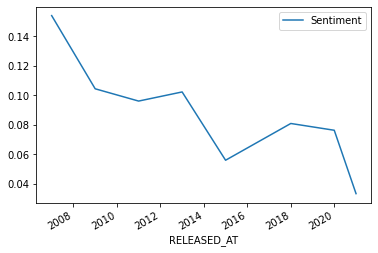

In [440]:
songs_resample.plot(label='Sentiment', legend=True)

In [441]:
#Calculate the mean percentage change of lyric sentiment 
# How has the lyric sentiment, on average, gotten annually between 2006 and 2020
songs_resample.pct_change().mean() * 100

-13.764330940001884

In [442]:
#Resample dataframe lyrics by year. Get all the lyrics for every song for each year
lyrics_resample = songs_df['LYRICS'].resample('Y').sum()

In [447]:
lyrics_resample

RELEASED_AT
2006-12-31    he said the way my blue eyes shined put those ...
2007-12-31                                                    0
2008-12-31    we were both young when i first saw you i clos...
2009-12-31                                                    0
2010-12-31    i guess you really did it this time left yours...
2011-12-31                                                    0
2012-12-31    i remember when we broke up the first time say...
2013-12-31                                                    0
2014-12-31    flashing lights and we took a wrong turn and w...
2015-12-31                                                    0
2016-12-31                                                    0
2017-12-31    i don't like your little games don't like your...
2018-12-31                                                    0
2019-12-31    you are somebody that i don't know but you're ...
2020-12-31    my only one my smoking gun my eclipsed sun thi...
Freq: A-DEC, Name: LYRICS, d

In [444]:
#Use return_keywords function on lyrics_resample to get the top 20 keywords for each year
lyric_keywords = [return_keywords(x[1]) for x in lyrics_resample.iteritems() if x[1] != 0]

In [ ]:
lyric_keywords

We don't want the years where Taylor didn't publish any songs.


In [446]:
lyrics_resample_nozeros = pd.Series(data=[lyrics_resample['2006-12-31'], 
                                   lyrics_resample['2008-12-31'],
                                   lyrics_resample['2010-12-31'],
                                   lyrics_resample['2012-12-31'],
                                   lyrics_resample['2014-12-31'],
                                   lyrics_resample['2017-12-31'],
                                   lyrics_resample['2019-12-31'],
                                   lyrics_resample['2020-12-31']], 
                             index =["Timestamp('2006-12-31 00:00:00', freq='A-DEC')",
                                     "Timestamp('2008-12-31 00:00:00', freq='A-DEC')",
                                     "Timestamp('2010-12-31 00:00:00', freq='A-DEC')",
                                     "Timestamp('2012-12-31 00:00:00', freq='A-DEC')",
                                     "Timestamp('2014-12-31 00:00:00', freq='A-DEC')",
                                     "Timestamp('2017-12-31 00:00:00', freq='A-DEC')",
                                     "Timestamp('2019-12-31 00:00:00', freq='A-DEC')",
                                     "Timestamp('2020-12-31 00:00:00', freq='A-DEC')"])

9. Top keywords from each year 

In [448]:
#Put lyric_keywords into a DataFrame and include lyrics_resample and hot100_resample
keywords_df = pd.DataFrame(lyric_keywords)
keywords_df = keywords_df.set_index(lyrics_resample_nozeros.index)
keywords_df['Lyrics'] = lyrics_resample_nozeros
keywords_df['Sentiment'] = songs_resample

In [449]:
keywords_df.drop(['Sentiment'], axis=1)

,0,1,2,3,4,5,6,7,8,9,Lyrics
"Timestamp('2006-12-31 00:00:00', freq='A-DEC')",knows,thinking,like,mama know,looked,looking,looks,time,times,gone think,he said the way my blue eyes shined put those ...
"Timestamp('2008-12-31 00:00:00', freq='A-DEC')",little know,like,feeling,way,look,looks,looking,princess love,think,thinking,we were both young when i first saw you i clos...
"Timestamp('2010-12-31 00:00:00', freq='A-DEC')",liked,know,love,loved,lovely,times,looked,look,looking,looks,i guess you really did it this time left yours...
"Timestamp('2012-12-31 00:00:00', freq='A-DEC')",like,liked,know,knowing,time,times,timing,loved,loving,loves,i remember when we broke up the first time say...
"Timestamp('2014-12-31 00:00:00', freq='A-DEC')",loves,like end,baby,way love think straight,turn,turned,turning,remember,know,wonderland got lost,flashing lights and we took a wrong turn and w...
"Timestamp('2017-12-31 00:00:00', freq='A-DEC')",times,like little,love,loves,got,things baby,time honey,said,want,wanted,i don't like your little games don't like your...
"Timestamp('2019-12-31 00:00:00', freq='A-DEC')",like,know,knows,likely run,afternoon likes,love,wants loved,want,wanna,night,you are somebody that i don't know but you're ...
"Timestamp('2020-12-31 00:00:00', freq='A-DEC')",likes,time,know,knowing,knows,love,loved,loves,thinking,passed house like,my only one my smoking gun my eclipsed sun thi...
